# Introduction: Modeling

In this notebook, we will use the calculated feature matrices to train and test a machine learning model. Our objective is a model that can predict, on the first of the month, which customers will churn during the next 30 days.

In [1]:
import pandas as pd
import numpy as np

PARTITION_DIR = 's3://customer-churn-spark'

In [2]:
p0_fm = pd.read_csv(f'{PARTITION_DIR}/p0/MS-30_feature_matrix.csv')
p0_fm.head()

,msno,time,city,bd,registered_via,gender,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.price_difference),...,WEEKEND(LAST(transactions.membership_expire_date)),WEEKEND(LAST(logs.date)),DAY(LAST(transactions.transaction_date)),DAY(LAST(transactions.membership_expire_date)),DAY(LAST(logs.date)),MONTH(LAST(transactions.transaction_date)),MONTH(LAST(transactions.membership_expire_date)),MONTH(LAST(logs.date)),churn,days_to_next_churn
0,+9zx0+mA3IZQLyjmU88qbfqJ0q9okIfYZnDI6FqaN2o=,2015-01-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,+sZCvwt5NmFw4uE185pBid4cOxtXTHovIyPFqchulQg=,2015-01-01,1.0,0.0,7.0,NaN,30.0,149.0,149.0,0.0,...,1.0,0.0,1.0,1.0,NaN,1.0,2.0,NaN,0.0,379.0
2,+wzmLe86mMBeoIYoPedlt24WVTW6tabsRcaz81ZXBx0=,2015-01-01,1.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,/9+HJnqEryBbuH598zKqa8zb1Eypy927imqI9IWhJTk=,2015-01-01,8.0,29.0,9.0,male,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,472.0
4,/BAK3DkUpoUESh4t8qlWs16yop+sG3i3oPYDpv5uGI0=,2015-01-01,13.0,21.0,9.0,male,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [ ]:
# import findspark
# findspark.init('/usr/local/spark-2.3.1-bin-hadoop2.7/')
# import pyspark

# sc = pyspark.SparkContext(master = 'spark://ip-172-31-23-133.ec2.internal:7077', appName = 'retrieval')
# sc.stop()

## Function to Retrieve Data

In [3]:
def retrieve_data(partition_num, label_type = 'MS-30'):
    return pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_feature_matrix.csv', low_memory = False)

In [4]:
import random

N_PARTITIONS = 1000
partitions = list(range(N_PARTITIONS))

The next cell retrieves a number of feature matrices for training and for testing. This could be done in parallel, but does not take very long to do sequentially. 

In [5]:
random.seed(50)

# Set number of train and testing feature matrices
fms_to_get = 10
test_fms_to_get = 5

# Choose random sample of partitions
ps = random.sample(list(range(900)), fms_to_get + test_fms_to_get)

# Separate into training and testing
test_p = ps[:test_fms_to_get]
train_p = ps[test_fms_to_get:]


train_fms = []

for i, p in enumerate(train_p):
    print(f'{round(100 * (i / fms_to_get), 2)}% complete.', end = '\r')
    train_fms.append(retrieve_data(p))
    
feature_matrix = pd.concat(train_fms)
feature_matrix.shape

(263092, 252)

In [6]:
test_fms = []

for i, p in enumerate(test_p):
    print(f'{round(100 * (i / test_fms_to_get), 2)}% complete.', end = '\r')
    test_fms.append(retrieve_data(p))
    
test_feature_matrix = pd.concat(test_fms)
test_feature_matrix.shape

(129800, 252)

# Feature Preparation

The next blocks of code get the features ready for machine learning.

First we need to one hot encode the features. After doing this, we align the training and testing dataframes so they have the same columns.

In [7]:
feature_matrix = pd.get_dummies(feature_matrix.set_index('msno'))
test_feature_matrix = pd.get_dummies(test_feature_matrix.set_index('msno'))
feature_matrix, test_feature_matrix = feature_matrix.align(test_feature_matrix, join = 'inner', axis = 1)
feature_matrix.shape

(263092, 387)

Now we can extract the labels. There are two different problems: one is a binary classification of whether or not the customer will churn during the month. The other is a regression: how many days are there until the next churn.

In [8]:
y, test_y = np.array(feature_matrix.pop('churn')), np.array(test_feature_matrix.pop('churn'))
y_reg, test_y_reg = np.array(feature_matrix.pop('days_to_next_churn')), np.array(test_feature_matrix.pop('days_to_next_churn'))

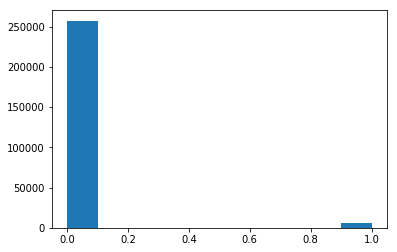

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y);

### Fill in Missing Values

We can fill in missing values using the median of the column. As an important note, the missing test values are filled in with the median of the corresponding training feature.

In [10]:
feature_matrix = feature_matrix.replace({np.inf: np.nan, -np.inf: np.nan}).\
                                fillna(feature_matrix.median()).fillna(0)

In [11]:
test_feature_matrix = test_feature_matrix.replace({np.inf: np.nan, -np.inf: np.nan}).\
                                          fillna(feature_matrix.median()).fillna(0)

In [12]:
np.any(feature_matrix.isnull()), np.any(np.isinf(feature_matrix))

(False, False)

# Machine Learning

## Baseline Model

We can use a logistic regression in order to see baseline performance on this problem. If the logistic regression works well enough, then there is no need to move to a more complex model.

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [14]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def evaluate(model, train, y, test, test_y):
    model.fit(train, y)
    
    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)
    
    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0]
    print(f"{name}\n")
    print(f'ROC AUC: {round(roc, 4)}')
    
    for metric in [precision_score, recall_score, f1_score]:
        print(f'{metric.__name__}: {round(metric(test_y, preds), 4)}')
        
    return model

evaluate(model, feature_matrix, y, test_feature_matrix, test_y)

LogisticRegression

ROC AUC: 0.5294
precision_score: 0.0072
recall_score: 0.0057
f1_score: 0.0064


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## More Complex Model

For a better machine learning model, we can move to the Random Forest Classifier. From the results of the logistic regression, this looks to be a non-linear problem which means we should use a model capable of learning a non-linear decision boundary.

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, max_depth = 20, n_jobs = -1)
model = evaluate(model, feature_matrix, y, test_feature_matrix, test_y)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier

ROC AUC: 0.9553
precision_score: 0.9418
recall_score: 0.3528
f1_score: 0.5133


In [16]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index = feature_matrix.columns).\
sort_values('importance', ascending = False)
fi.head()

,importance
TIME_SINCE_LAST(transactions.transaction_date),0.023557
LAST(transactions.DAY(membership_expire_date)),0.022873
DAY(LAST(transactions.membership_expire_date)),0.022667
"TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, membership_expire_date)",0.019445
TIME_SINCE_LAST(logs.date),0.017653


In [17]:
model = RandomForestClassifier(n_estimators = 100, max_depth = 20, n_jobs = -1)
model.fit(feature_matrix[['TIME_SINCE_LAST(transactions.transaction_date)',
                          'LAST(transactions.DAY(membership_expire_date))']], np.array(y))

p = model.predict_proba(test_feature_matrix[['TIME_SINCE_LAST(transactions.transaction_date)',
                          'LAST(transactions.DAY(membership_expire_date))']])[:, 1]
roc_auc_score(np.array(test_y), p)

0.7362488338696902

In [18]:
1 - np.mean(test_y)

0.9770493066255778

In [19]:
feature_matrix.iloc[np.where(y == 1)[0]]['TIME_SINCE_LAST(transactions.transaction_date)'].describe() / (3600 * 24)

count      0.068229
mean     202.495165
std      186.021711
min        0.000000
25%       31.000000
50%      140.000000
75%      393.000000
max      757.000000
Name: TIME_SINCE_LAST(transactions.transaction_date), dtype: float64

In [20]:
feature_matrix.iloc[np.where(y == 0)[0]]['TIME_SINCE_LAST(transactions.transaction_date)'].describe()

count    2.571970e+05
mean     2.111073e+07
std      1.919956e+07
min      0.000000e+00
25%      3.024000e+06
50%      1.702080e+07
75%      3.456000e+07
max      6.825600e+07
Name: TIME_SINCE_LAST(transactions.transaction_date), dtype: float64